# [COM4513/6513] Assignment: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras, Nafise Sadat Moosavi



**Objective:** This assignment aims to develop a Feedforward Neural Network for classifying news articles into three topics: *Politics*, *Sports*, and *Economy*.

**Dataset:**

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

Class 1: Politics, Class 2: Sports, Class 3: Economy

* `data_topic/train.csv`: 2,400 articles (800 per class) for training.
* `data_topic/dev.csv`: 150 articles (50 per class) for hyperparameter tuning and validation.
* `data_topic/test.csv`: 900 articles (300 per class) for final evaluation.

**Tasks:**

*  **Text Preprocessing (1 mark):**
    * Implement methods to convert raw text into input vectors suitable for your neural network.
   

*  **Feedforward Neural Network Implementation (3 marks):** The network consists of the following components:
    * **Input Layer:** Implement a one-hot encoding followed by an Embedding weight matrix. (**1 mark**)
    * **Hidden Layer:** Calculate the mean embedding vector of all words in the input, and apply a ReLU activation function. (**1 mark**)
    * **Output Layer:** Implement a softmax activation function for multi-class classification. (**1 mark**)
    

*  **Training with Stochastic Gradient Descent (SGD) (6 marks):**
    * Implement the forward pass to compute intermediate outputs. (**2 marks**)
    * Implement the backward pass to compute gradients and update weights. (**3 marks**)
    * Implement and use the Categorical Cross-entropy loss as the objective function. (**1 mark**)
    * Implement and apply dropout regularization after the hidden layer. (**1 mark**)

*  **Hyperparameter Tuning (2 marks):**
    * Systematically tune the following hyperparameters:
        * Learning rate (suggest small values).
        * Embedding size (e.g. 50, 300, 500).
        * Dropout rate (e.g. 0.2, 0.5).
    * Present training and validation performance (loss and accuracy) for different hyperparameter combinations using tables or graphs.
    

*  **Pre-trained Embeddings (GloVe) (1 mark)**:
    * Re-train your neural network using pre-trained GloVe embeddings (300 dimensions) from Common Crawl.
    * Initialize the embedding layer with pre-trained weights.
    * Freeze the embedding weights during training (do not update them).
    * Repeat hyperparameter tuning and learning process analysis.
    * Compare performance with the model using randomly initialized embeddings.

*  **Network Extension (3 marks):**
    * Extend the feedforward network by adding one or two additional hidden layers.
    * Repeat hyperparameter tuning (using a representative subset of combinations).
    * Analyze and discuss the impact of adding more hidden layers on performance.

    
*  **Analysis and Discussion of Results (12 marks):**
    * Justify briefly and concisely all design choices, e.g. text processing, hyperparameters, network architecture. (**2 marks*) 
    * Plot the training and validation loss curves across epochs for all models (excluding the hyperparameter tuning phase). Analyze the learning curves to determine if the model is overfitting, underfitting, or well-fitted. (**2 marks**)
    * Provide a detailed analysis of results, including:
        * Explanations for performance differences between models. (**3 marks**)
        * Error analysis, showing examples and discussion of misclassifications. (**3 marks**)
    * Please provide short and concise justifications.

*  **Code Documentation and Efficiency (3 marks):**
    * Provide well-documented and commented code. (1 mark)
    * Implement efficient solutions using NumPy arrays where possible, ensuring the notebook executes within 10 minutes, excluding hyperparameter tuning and loading pre-trained vectors, on a standard computer (e.g. Intel Core i5, 8/16GB RAM). (2 marks)
    * Refer to Lab 1 for efficiency tips.

**Pre-trained Embeddings:**

* Download GloVe embeddings (glove.840B.300d.zip) from [http://nlp.stanford.edu/data/glove.840B.300d.zip](http://nlp.stanford.edu/data/glove.840B.300d.zip).

**Memory Management:**

* Use `del W` and `gc.collect()` to free memory after each experiment.

**Memory Management:**

* Use `del W` and `gc.collect()` to free memory after each experiment.

**Note:** 
This assignment is designed to be challenging and requires a strong understanding of the underlying mathematical concepts introduced in the class beyond lecture slides. Students are encouraged to consult Chapters 4, 5, 6 and 7 from the [course textbook](https://web.stanford.edu/~jurafsky/slp3/). Good luck!


### Submission Instructions

You **must** submit a Jupyter Notebook file (assignment_yourusername.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`, you need to have a Latex distribution installed e.g. MikTex or MacTex and pandoc). If you are unable to export the pdf via Latex, you can print the notebook web page to a pdf file from your browser (e.g. on Firefox: File->Print->Save to PDF). Failure to submit both the .ipynb and pdf files will result in mark deductions.


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any additional functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results and discussion is as important as the implementation and accuracy of your models. Please be brief and consice in your discussion and analyses. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **15:00 on Thursday, 3 Apr 2025** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade. Use of GenAI is not permitted for this assignment and will be considered as use of unfair means.



In [399]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [400]:
train_df = pd.read_csv('./data_topic/train.csv', header=None) 
dev_df = pd.read_csv('./data_topic/dev.csv', header=None)
test_df = pd.read_csv('./data_topic/test.csv', header=None)

print("Train sample:") 
print(train_df.head())

print("\nDev sample:")
print(dev_df.head())

print("\nTest sample:")
print(test_df.head())

Train sample:
   0                                                  1
0  1  Reuters - Venezuelans turned out early\and in ...
1  1  Reuters - South Korean police used water canno...
2  1  Reuters - Thousands of Palestinian\prisoners i...
3  1  AFP - Sporadic gunfire and shelling took place...
4  1  AP - Dozens of Rwandan soldiers flew into Suda...

Dev sample:
   0                                                  1
0  1  BAGHDAD, Iraq - An Islamic militant group that...
1  1  Parts of Los Angeles international airport are...
2  1  AFP - Facing a issue that once tripped up his ...
3  1  The leader of militant Lebanese group Hezbolla...
4  1  JAKARTA : ASEAN finance ministers ended a meet...

Test sample:
   0                                                  1
0  1  Canadian Press - VANCOUVER (CP) - The sister o...
1  1  AP - The man who claims Gov. James E. McGreeve...
2  1  NAJAF, Iraq - Explosions and gunfire rattled t...
3  1  LOURDES, France - A frail Pope John Paul II, b...
4  1  S

In [401]:

#The dataset was initially loaded without column names,
#Instead of default numeric column indices (0, 1), 
#descriptive names (label, text) make the dataset easier to work with


train_df.columns = ['label', 'text']
dev_df.columns = ['label', 'text']
test_df.columns = ['label', 'text']

print("Train sample:")
print(train_df.head())

Train sample:
   label                                               text
0      1  Reuters - Venezuelans turned out early\and in ...
1      1  Reuters - South Korean police used water canno...
2      1  Reuters - Thousands of Palestinian\prisoners i...
3      1  AFP - Sporadic gunfire and shelling took place...
4      1  AP - Dozens of Rwandan soldiers flew into Suda...


# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [402]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


In [403]:
# Import necessary modules
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter

# Download NLTK tokenizer models if you haven't already
nltk.download('punkt')

# Define the preprocess function
def preprocess_text(text, stop_words):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize the text
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Preprocess all texts in the dataset using the correct column name ('text')
train_tokens = train_df['text'].apply(preprocess_text, stop_words=stop_words)
dev_tokens = dev_df['text'].apply(preprocess_text, stop_words=stop_words)
test_tokens = test_df['text'].apply(preprocess_text, stop_words=stop_words)

# Flatten all tokens to count frequency
all_tokens = train_tokens.explode().tolist() + dev_tokens.explode().tolist() + test_tokens.explode().tolist()

# Create a Counter object to count word frequencies in the corpus
word_freq = Counter(all_tokens)

# Filter out unigrams that appear in fewer than K documents (e.g., K=5)
K = 5
word_freq = {word: count for word, count in word_freq.items() if count >= K}

# Convert word_freq back into a Counter object
word_freq = Counter(word_freq)

# Create vocabulary by keeping only the top-N frequent words (e.g., N=10000)
N = 10000
vocabulary = [word for word, _ in word_freq.most_common(N)]  # Use most_common() method

# Create a mapping from word to index
word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}

# Function to convert tokenized text into index representation
def text_to_indices(tokens, word_to_idx):
    return [word_to_idx[word] for word in tokens if word in word_to_idx]

# Convert all documents into lists of indices
train_indices = train_tokens.apply(text_to_indices, word_to_idx=word_to_idx)
dev_indices = dev_tokens.apply(text_to_indices, word_to_idx=word_to_idx)
test_indices = test_tokens.apply(text_to_indices, word_to_idx=word_to_idx)

# Display a sample of the indices
print("Train sample after converting to indices:")
print(train_indices.head())


[nltk_data] Downloading package punkt to /Users/atheer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Train sample after converting to indices:
0    [0, 1135, 788, 28, 1136, 1226, 20, 334, 728, 1...
1    [0, 127, 1061, 130, 512, 539, 2084, 20, 120, 5...
2    [0, 365, 133, 564, 2085, 729, 20, 349, 240, 64...
3    [66, 2086, 156, 472, 1063, 730, 226, 127, 649,...
4    [8, 1137, 1821, 421, 2089, 36, 293, 1227, 314,...
Name: text, dtype: object


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [404]:

 #Tokenizing the text, removing stopwords, and extracting unigrams and n-grams from the documents



def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    
    tokens = re.findall(token_pattern, x_raw.lower()) 

  
    tokens = [t for t in tokens if t not in stop_words]   

     #Extracting ngrams from the documents
    x = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        for i in range(len(tokens) - n + 1):
            ngram = ' '.join(tokens[i:i+n])
            x.append(ngram)

    # Filter using vocab
    if vocab:
        x = [ngram for ngram in x if ngram in vocab]

    return x



In [405]:
# Print the vocab content
print("Vocabulary:", vocab)

# Extract unigrams and bigrams without vocab filtering
text = "Supporters and rivals warn of possible fraud"
features_raw = extract_ngrams(text, ngram_range=(1, 3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=set())

# Print raw features (no vocab filtering)
print("Raw features:", features_raw)

# Check tokenization for case issues
tokens = [word.lower() for word in features_raw]  # Convert to lowercase to match vocab (if case is an issue)
print("Tokens in lowercase:", tokens)

# Now filter using the vocabulary (with case-insensitive matching if needed)
features_filtered = extract_ngrams(text, ngram_range=(1, 3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab)

# Print the final features after vocab filtering
print("Filtered features:", features_filtered)


Vocabulary: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [397]:
# Extract unigrams and bigrams without vocabulary filtering for debugging
text = "Supporters and rivals warn of possible fraud"
features_raw = extract_ngrams(text, ngram_range=(1, 3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=set())

# Print raw features (no vocab filtering)
print("Raw features:", features_raw)

# Now filter using the vocabulary
features_filtered = extract_ngrams(text, ngram_range=(1, 3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab)

# Print the final features after vocab filtering
print("Filtered features:", features_filtered)


Raw features: ['supporters', 'rivals', 'warn', 'possible', 'fraud', 'supporters rivals', 'rivals warn', 'warn possible', 'possible fraud', 'supporters rivals warn', 'rivals warn possible', 'warn possible fraud']
Filtered features: []


### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency (i.e. number of documents that an ngram appears) as values.
- `ngram_counts`: counts of each ngram in vocab


In [339]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [340]:
pip install --upgrade pip

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip None
error: uninstall-no-record-file

× Cannot uninstall pip None
╰─> The package's contents are unknown: no RECORD file was found for pip.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps pip==23.3.1
Note: you may need to restart the kernel to use updated packages.


In [341]:
from nltk.util import ngrams


In [342]:
from itertools import tee, islice

def ngrams(tokens, n):
    # Create a sliding window of size n over the tokens
    iters = tee(tokens, n)
    for i, it in enumerate(iters):
        for _ in range(i):
            next(it, None)
    return zip(*iters)


In [343]:

 #Tokenizing the text, removing stopwords, and extracting unigrams and n-grams from the documents


def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    
    tokens = re.findall(token_pattern, x_raw.lower()) 

  
    tokens = [t for t in tokens if t not in stop_words]   

     #Extracting ngrams from the documents
    x = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        for i in range(len(tokens) - n + 1):
            ngram = ' '.join(tokens[i:i+n])
            x.append(ngram)

    # Filter using vocab
    if vocab:
        x = [ngram for ngram in x if ngram in vocab]

    return x


In [321]:
from collections import Counter
import re
from itertools import chain, combinations


 #Creating a vocabulary from the unigrams, calculating document frequencies (DF), 
 #and raw frequencies (TF), and then filtering the vocabulary based on document frequency
 #and keeping the top-N most frequent unigrams
 


from collections import Counter
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    df = Counter() 
    ngram_counts = Counter() 

    for doc in X_raw:
        ngrams = extract_ngrams(doc, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
        
         #Counting document frequency 
        df.update(set(ngrams))
        
         #Counting total ngram occurrences
        ngram_counts.update(ngrams)

    # Filter based on minimum document frequency
    if min_df > 0:
        df = Counter({ng: freq for ng, freq in df.items() if freq >= min_df})
    
    if keep_topN > 0:
        most_common = ngram_counts.most_common(keep_topN)
        allowed_ngrams = set([ng for ng, _ in most_common])
        df = Counter({ng: freq for ng, freq in df.items() if ng in allowed_ngrams})
        ngram_counts = Counter({ng: count for ng, count in ngram_counts.items() if ng in allowed_ngrams})
    
    vocab = set(df.keys()) 
    
    return vocab, df, ngram_counts


Processing document: Supporters of the new proposal argue it's possible fraud.
Extracted ngrams: ['supporters', 'new', 'proposal', 'argue', 'it', 'possible', 'fraud', 'supporters new', 'new proposal', 'proposal argue', 'argue it', 'it possible', 'possible fraud']
Processing document: Rivals warn of potential fraud in the system.
Extracted ngrams: ['rivals', 'warn', 'potential', 'fraud', 'in', 'system', 'rivals warn', 'warn potential', 'potential fraud', 'fraud in', 'in system']
Processing document: The proposal could lead to possible fraud, supporters say.
Extracted ngrams: ['proposal', 'could', 'lead', 'to', 'possible', 'fraud', 'supporters', 'say', 'proposal could', 'could lead', 'lead to', 'to possible', 'possible fraud', 'fraud supporters', 'supporters say']
Vocabulary: {'proposal', 'possible', 'supporters', 'possible fraud', 'fraud'}
Document Frequency (DF): Counter({'fraud': 3, 'proposal': 2, 'possible': 2, 'supporters': 2, 'possible fraud': 2})
Ngram Counts: Counter({'fraud': 3,

### 1- Unigrams: The output only includes unigrams and a few bigrams like 'possible fraud'.
### 2- N-grams Range: The specified ngram_range=(1, 2) should extract unigrams and bigrams, but it looks like only certain bigrams have been captured.

In [344]:
stop_words = ['a', 'in', 'on', 'at', 'and', 'or', 'to', 'the', 'of', 'an', 'by', 'as', 'is', 'was', 'were', 'been', 'be', 'are', 'for', 'this', 'that', 'these', 'those', 'you', 'i', 'if', 'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has', 'do', 'did', 'can', 'could', 'who', 'which', 'what', 'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their', 'his', 'her', 'they', 'them', 'from', 'with', 'its']

# Create the vocabulary using the training data
vocab, df, ngram_counts = get_vocab(train_df['text'], ngram_range=(1, 2), min_df=5, keep_topN=1000, stop_words=stop_words)

print("Vocabulary (first 10 entries):", list(vocab)[:10])
print("Document Frequencies (first 10 entries):", df.most_common(10))
print("Raw Frequencies (first 10 entries):", ngram_counts.most_common(10))

Processing document: Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.
Extracted ngrams: ['reuters', 'venezuelans', 'turned', 'out', 'early', 'large', 'numbers', 'sunday', 'vote', 'historic', 'referendum', 'either', 'remove', 'left', 'wing', 'president', 'hugo', 'chavez', 'office', 'give', 'him', 'new', 'mandate', 'govern', 'next', 'two', 'years', 'reuters venezuelans', 'venezuelans turned', 'turned out', 'out early', 'early large', 'large numbers', 'numbers sunday', 'sunday vote', 'vote historic', 'historic referendum', 'referendum either', 'either remove', 'remove left', 'left wing', 'wing president', 'president hugo', 'hugo chavez', 'chavez office', 'office give', 'give him', 'him new', 'new mandate', 'mandate govern', 'govern next', 'next two', 'two years']
Processing document: Reuters - South Korean pol

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [345]:
#creating vocab2id and id2vocab dictionaries that map words to indices and indices to vocabulary

vocab2id = {word: idx for idx, word in enumerate(sorted(vocab))}

id2vocab = {idx: word for word, idx in vocab2id.items()}


print("Sample vocab2id:", dict(list(vocab2id.items())[:10]))
print("Sample id2vocab:", dict(list(id2vocab.items())[:10]))

Sample vocab2id: {'about': 0, 'according': 1, 'accused': 2, 'across': 3, 'action': 4, 'afghanistan': 5, 'afp': 6, 'africa': 7, 'african': 8, 'after': 9}
Sample id2vocab: {0: 'about', 1: 'according', 2: 'accused', 3: 'across', 4: 'action', 5: 'afghanistan', 6: 'afp', 7: 'africa', 8: 'african', 9: 'after'}


In [346]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
              'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'so', 've', 'their',
              'his', 'her', 'them', 'from', 'with', 'its']

# Combine all raw texts from training and development sets
X_raw_all = train_df["text"].tolist() + dev_df["text"].tolist()

# Create vocabulary of unigrams 
vocab, df, ngram_counts = get_vocab(
    X_raw=X_raw_all,
    ngram_range=(1, 1),  # unigram only
    token_pattern=r'\b[A-Za-z][A-Za-z]+\b',  # token pattern to extract words
    min_df=2,              # remove unigrams appearing in fewer than 2 documents
    keep_topN=3000,        # top 3000 most frequent unigrams
    stop_words=stop_words  
)

print("Sample Vocabulary:", list(vocab)[:10])
print("Total Vocab Size:", len(vocab))
print("Top 10 Most Frequent N-grams:", ngram_counts.most_common(10))
print("Top 10 N-grams by Document Frequency:", df.most_common(10))


Processing document: Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.
Extracted ngrams: ['reuters', 'venezuelans', 'turned', 'out', 'early', 'large', 'numbers', 'sunday', 'vote', 'historic', 'referendum', 'either', 'remove', 'left', 'wing', 'president', 'hugo', 'chavez', 'office', 'give', 'him', 'new', 'mandate', 'govern', 'next', 'two', 'years']
Processing document: Reuters - South Korean police used water cannon in\central Seoul Sunday to disperse at least 7,000 protesters\urging the government to reverse a controversial decision to\send more troops to Iraq.
Extracted ngrams: ['reuters', 'south', 'korean', 'police', 'used', 'water', 'cannon', 'central', 'seoul', 'sunday', 'disperse', 'least', 'protesters', 'urging', 'government', 'reverse', 'controversial', 'decision', 'send', 'more', 'troops', 'iraq']
Pr

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [347]:
#creating vocab2id and id2vocab dictionaries that map words to indices and indices to vocabulary

vocab2id = {word: idx for idx, word in enumerate(sorted(vocab))}

id2vocab = {idx: word for word, idx in vocab2id.items()}


print("Sample vocab2id:", dict(list(vocab2id.items())[:10]))
print("Sample id2vocab:", dict(list(id2vocab.items())[:10]))

Sample vocab2id: {'abandon': 0, 'able': 1, 'about': 2, 'above': 3, 'abroad': 4, 'ac': 5, 'accept': 6, 'accepted': 7, 'accident': 8, 'according': 9}
Sample id2vocab: {0: 'abandon', 1: 'able', 2: 'about', 3: 'above', 4: 'abroad', 5: 'ac', 6: 'accept', 7: 'accepted', 8: 'accident', 9: 'according'}


In [348]:

def convert_texts_to_vocab_words(texts, vocab):
    return [[word for word in text if word in vocab] for text in texts]

# Applying transformation to training, dev, and test sets
train_texts = [extract_ngrams(text, ngram_range=(1, 1), stop_words=stop_words) for text in train_df['text']]
dev_texts = [extract_ngrams(text, ngram_range=(1, 1), stop_words=stop_words) for text in dev_df['text']]
test_texts = [extract_ngrams(text, ngram_range=(1, 1), stop_words=stop_words) for text in test_df['text']]

train_vocab_texts = convert_texts_to_vocab_words(train_texts, vocab)
dev_vocab_texts = convert_texts_to_vocab_words(dev_texts, vocab)
test_vocab_texts = convert_texts_to_vocab_words(test_texts, vocab)

print("Example Train Document (Words in Vocab):", train_vocab_texts[0])
print("Example Dev Document (Words in Vocab):", dev_vocab_texts[0])
print("Example Test Document (Words in Vocab):", test_vocab_texts[0])

Example Train Document (Words in Vocab): ['reuters', 'venezuelans', 'turned', 'out', 'early', 'large', 'numbers', 'sunday', 'vote', 'historic', 'referendum', 'either', 'remove', 'left', 'wing', 'president', 'hugo', 'chavez', 'office', 'give', 'him', 'new', 'mandate', 'govern', 'next', 'two', 'years']
Example Dev Document (Words in Vocab): ['baghdad', 'iraq', 'islamic', 'militant', 'group', 'claimed', 'kidnapped', 'two', 'french', 'journalists', 'said', 'would', 'soon', 'decide', 'fate', 'according', 'message', 'posted', 'web', 'site', 'friday', 'iraqi', 'called', 'chance', 'release', 'quot']
Example Test Document (Words in Vocab): ['canadian', 'press', 'cp', 'man', 'died', 'after', 'violent', 'police', 'demanded', 'city', 'chief', 'defending', 'officer']


In [349]:
def docs_to_indices(X_raw, vocab, vocab2id, stop_words):
    X_indices = []
    for doc in X_raw:
      
        tokens = extract_ngrams(doc, ngram_range=(1, 1), stop_words=stop_words, vocab=vocab)
        indices = [vocab2id[token] for token in tokens if token in vocab2id]
        X_indices.append(indices)
    return X_indices

X_tr = docs_to_indices(train_df['text'], vocab, vocab2id, stop_words)
X_dev = docs_to_indices(dev_df['text'], vocab, vocab2id, stop_words)
X_test = docs_to_indices(test_df['text'], vocab, vocab2id, stop_words)

print("First document (indices):", X_tr[0])
print("Decoded:", [id2vocab[idx] for idx in X_tr[0]])

First document (indices): [2216, 2843, 2784, 1836, 801, 1445, 1769, 2570, 2869, 1188, 2150, 822, 2182, 1472, 2942, 1994, 1233, 465, 1785, 1073, 1184, 1743, 1565, 1096, 1747, 2792, 2987]
Decoded: ['reuters', 'venezuelans', 'turned', 'out', 'early', 'large', 'numbers', 'sunday', 'vote', 'historic', 'referendum', 'either', 'remove', 'left', 'wing', 'president', 'hugo', 'chavez', 'office', 'give', 'him', 'new', 'mandate', 'govern', 'next', 'two', 'years']


In [350]:
print(vocab)  # Print all words in vocab (set will not be ordered)


{'washington', 'mike', 'doubled', 'picture', 'project', 'canadian', 'operation', 'rise', 'putter', 'plant', 'areas', 'neighboring', 'situation', 'uk', 'possibly', 'roddick', 'caribbean', 'recall', 'slashed', 'protection', 'bundled', 'extending', 'teixeira', 'inspired', 'keep', 'target', 'reserve', 'homered', 'homeless', 'jean', 'deadline', 'replaced', 'illinois', 'egypt', 'records', 'insisted', 'sprint', 'offense', 'winter', 'practices', 'vice', 'brian', 'basra', 'exhibition', 'teams', 'polls', 'seat', 'indian', 'year', 'himalayan', 'going', 'slower', 'army', 'lifepoint', 'send', 'should', 'nature', 'temporary', 'whether', 'december', 'reportedly', 'bls', 'pounded', 'alex', 'done', 'second', 'against', 'materials', 'anyone', 'added', 'upbeat', 'row', 'thursday', 'dozen', 'thailand', 'supporters', 'round', 'division', 'meet', 'temple', 'haven', 'table', 'nl', 'finance', 'veterans', 'denver', 'explosion', 'den', 'andy', 'kostas', 'bloody', 'performance', 'suzuki', 'significantly', 'askin

Then convert them into lists of indices in the vocabulary:

In [351]:
def docs_to_tokens(X_raw, vocab, stop_words):
    X_tokens = []
    for doc in X_raw:
        # Extract unigrams (1-grams) from the document
        tokens = extract_ngrams(doc, ngram_range=(1, 1), stop_words=stop_words)
        
        # Filter tokens that are in the vocab
        filtered_tokens = [token for token in tokens if token in vocab]
        
        # Append the filtered tokens to the list
        X_tokens.append(filtered_tokens)
    
    return X_tokens

# Applying transformation to training, dev, and test sets
X_tr_tokens = docs_to_tokens(train_df["text"], vocab, stop_words)
X_dev_tokens = docs_to_tokens(dev_df["text"], vocab, stop_words)
X_test_tokens = docs_to_tokens(test_df["text"], vocab, stop_words)

print("Tokenized document (X_tr_tokens[0]):", X_tr_tokens[0])


Tokenized document (X_tr_tokens[0]): ['reuters', 'venezuelans', 'turned', 'out', 'early', 'large', 'numbers', 'sunday', 'vote', 'historic', 'referendum', 'either', 'remove', 'left', 'wing', 'president', 'hugo', 'chavez', 'office', 'give', 'him', 'new', 'mandate', 'govern', 'next', 'two', 'years']


In [352]:
def tokens_to_indices(X_tokens, vocab2id):
    X_indices = []
    for tokens in X_tokens:
        indices = [vocab2id[token] for token in tokens if token in vocab2id]
        X_indices.append(indices)
    return X_indices


X_tr = tokens_to_indices(X_tr_tokens, vocab2id)
X_dev = tokens_to_indices(X_dev_tokens, vocab2id)
X_test = tokens_to_indices(X_test_tokens, vocab2id)

print("Example document (indices):", X_tr[0])
print("Decoded:", [id2vocab[i] for i in X_tr[0]])

Example document (indices): [2216, 2843, 2784, 1836, 801, 1445, 1769, 2570, 2869, 1188, 2150, 822, 2182, 1472, 2942, 1994, 1233, 465, 1785, 1073, 1184, 1743, 1565, 1096, 1747, 2792, 2987]
Decoded: ['reuters', 'venezuelans', 'turned', 'out', 'early', 'large', 'numbers', 'sunday', 'vote', 'historic', 'referendum', 'either', 'remove', 'left', 'wing', 'president', 'hugo', 'chavez', 'office', 'give', 'him', 'new', 'mandate', 'govern', 'next', 'two', 'years']


Put the labels `Y` for train, dev and test sets into arrays: 

In [353]:
Y_tr = train_df["label"].values
Y_dev = dev_df["label"].values
Y_test = test_df["label"].values

print("Train Labels Shape:", Y_tr.shape, "| Unique:", np.unique(Y_tr))
print("Dev Labels Shape:", Y_dev.shape, "| Unique:", np.unique(Y_dev))
print("Test Labels Shape:", Y_test.shape, "| Unique:", np.unique(Y_test))

Train Labels Shape: (2400,) | Unique: [1 2 3]
Dev Labels Shape: (150,) | Unique: [1 2 3]
Test Labels Shape: (900,) | Unique: [1 2 3]


In [354]:
#Converting labels from DataFrame to NumPy arrays
#labels from our DataFrame are converted into NumPy arrays, 
#and we corrected the labels by subtracting 1.

Y_tr = train_df["label"].values - 1
Y_dev = dev_df["label"].values - 1
Y_test = test_df["label"].values - 1

print("Fixed Train Labels Unique:", np.unique(Y_tr))
print("Fixed Dev Labels Unique:", np.unique(Y_dev))
print("Fixed Test Labels Unique:", np.unique(Y_test))

Fixed Train Labels Unique: [0 1 2]
Fixed Dev Labels Unique: [0 1 2]
Fixed Test Labels Unique: [0 1 2]


In [355]:
num_classes = len(np.unique(Y_tr))

# One-hot encoding
def one_hot_encode(Y, num_classes):
    return np.eye(num_classes)[Y]

Y_tr_oh = one_hot_encode(Y_tr, num_classes)
Y_dev_oh = one_hot_encode(Y_dev, num_classes)
Y_test_oh = one_hot_encode(Y_test, num_classes)

print("One-hot encoded sample:", Y_tr_oh[0])
print("Shape of Y_tr_oh:", Y_tr_oh.shape)

One-hot encoded sample: [1. 0. 0.]
Shape of Y_tr_oh: (2400, 3)


# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [356]:
import numpy as np

def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val=0.1):
    
    W = {}

    
    W[0] = np.random.uniform(-init_val, init_val, size=(vocab_size, embedding_dim)).astype(np.float32) # Layer 0: Embedding matrix

    layer_input_dim = embedding_dim
    layer_index = 1  # Starting from W[1] after embedding

   
    for h_dim in hidden_dim:  # Hidden layers
        W[layer_index] = np.random.uniform(-init_val, init_val, size=(layer_input_dim, h_dim)).astype(np.float32)
        layer_input_dim = h_dim
        layer_index += 1

    
    W[layer_index] = np.random.uniform(-init_val, init_val, size=(layer_input_dim, num_classes)).astype(np.float32) # Output layer

    return W


In [371]:
# Dynamically set num_classes based on the unique values in Y_tr (training labels)


# Call the network_weights function with the dynamically set num_classes
W = network_weights(vocab_size=3, embedding_dim=4, hidden_dim=[2], num_classes=2)

# Print the shapes of the weight matrices
for i in range(len(W)):
    print(f"Shape of W[{i}]: {W[i].shape}")

Shape of W[0]: (3, 4)
Shape of W[1]: (4, 2)
Shape of W[2]: (2, 2)


Then you need to develop a `softmax` function to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [372]:
def softmax(z):
  
    z = np.array(z, dtype=np.float32)  
    z_stable = z - np.max(z)           
    exp_z = np.exp(z_stable)
    sig = exp_z / np.sum(exp_z)
    return sig

In [373]:
z = [2.0, 1.0, 0.1]
output = softmax(z)
print("Softmax output:", output)


Softmax output: [0.6590012 0.242433  0.0985659]


Now you need to implement the categorical cross entropy loss that depends only on the true label `y` and the class probabilities vector `y_preds`:


In [374]:
def categorical_loss(y, y_preds):
    
    # Add epsilon to avoid log(0)
    epsilon = 1e-12
    y_preds = np.clip(y_preds, epsilon, 1. - epsilon)  
    l = -np.sum(y * np.log(y_preds))
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [375]:
def relu(z):
    a = np.maximum(z, 0).copy()
    return a

def relu_derivative(z):
    dz = (z > 0).astype(np.float32).copy()
    return dz

In [376]:
z = np.array([-1.0, 2.0, 0.5, -0.3])

# ReLU activation
relu_output = relu(z)
print("ReLU Output:", relu_output)

# ReLU Derivative
relu_derivative_output = relu_derivative(z)
print("ReLU Derivative Output:", relu_derivative_output)


ReLU Output: [0.  2.  0.5 0. ]
ReLU Derivative Output: [0. 1. 1. 0.]


During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [377]:
def dropout_mask(size, dropout_rate):
    """
    Generates a dropout mask of given size.
    Each element has a probability (1 - dropout_rate) to be kept (1), otherwise 0.
    """
   
    dropout_vec = (np.random.rand(size) > dropout_rate).astype(np.float32)  # Generate binary mask: 1 with probability (1 - dropout_rate), else 0
    
    return dropout_vec
    
    

In [378]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
[1. 1. 0. 1. 0. 1. 0. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [379]:
def forward_pass(x, W, dropout_rate=0.2):
 
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []

    # Average word embeddings
    emb_matrix = W[0]  
    if len(x) == 0:
        x_emb = np.zeros(emb_matrix.shape[1], dtype=np.float32)
    else:
        x_emb = np.mean(emb_matrix[x], axis=0)

    a = x_emb  

    # Forward through hidden layers 
    for i in range(1, len(W) - 1):
        h = np.dot(a, W[i])  # linear transformation
        a = relu(h)          # ReLU activation
        d = dropout_mask(len(a), dropout_rate)  # Dropout mask
        a *= d              

        h_vecs.append(h)
        a_vecs.append(a.copy())  # Storing copies to avoid in-place changes
        dropout_vecs.append(d)

  
    y_pred = softmax(np.dot(a, W[max(W.keys())]))


    #Storing results in dictionary 
    out_vals["h"] = h_vecs
    out_vals["a"] = a_vecs
    out_vals["dropout_vecs"] = dropout_vecs
    out_vals["y_pred"] = y_pred

    return out_vals

    

In [380]:
# Example of calling the functions
#####################vocab_size = 3
embedding_dim = 4
hidden_dim = [2]  # Keeping a smaller hidden layer size
num_classes = 3

W = network_weights(vocab_size, embedding_dim, hidden_dim, num_classes)

# Forward pass example with dummy input
x = [0, 1, 2]  # Example of word indices in a document
dropout_rate = 0.2

out_vals = forward_pass(x, W, dropout_rate)

# Print output values
print("Hidden Layer Activations (a):", out_vals["a"])
print("Output Prediction (y_pred):", out_vals["y_pred"])

Hidden Layer Activations (a): [array([0., 0.], dtype=float32)]
Output Prediction (y_pred): [0.33333334 0.33333334 0.33333334]


The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [381]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
  

   
    a_last = out_vals["a"][-1] if out_vals["a"] else np.mean(W[0][x], axis=0)
    y_pred = out_vals["y_pred"]
    delta = y_pred - y  # gradient of cross-entropy + softmax
    dW_out = np.outer(a_last, delta)  # shape: (hidden_dim, num_classes)
    W[max(W.keys())] -= lr * dW_out  # update output layer weights

    for i in reversed(range(1, len(W) - 1)):
        h = out_vals["h"][i - 1]
        a_prev = out_vals["a"][i - 1] if i > 1 else np.mean(W[0][x], axis=0)
        d_mask = out_vals["dropout_vecs"][i - 1]

       
        delta = np.dot(W[i + 1], delta)
        delta *= relu_derivative(h)
        delta *= d_mask

     
        dW = np.outer(a_prev, delta)
        W[i] -= lr * dW

    if not freeze_emb:
        delta = np.dot(W[1], delta)
        for idx in x:
            W[0][idx] -= lr * delta / len(x)  

    return W


Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [382]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
   
    
    training_loss_history = []
    validation_loss_history = []
    prev_val_loss = float('inf')  # for early stopping

    for epoch in range(epochs):
        train_loss = 0

        indices = np.random.permutation(len(X_tr))
        X_tr = [X_tr[i] for i in indices]
        Y_tr = [Y_tr[i] for i in indices]

        # Mini-batch training: process 1 example at a time
        for i in range(len(X_tr)):
            x = X_tr[i]
            y = Y_tr[i]

            # Forward pass
            out_vals = forward_pass(x, W, dropout_rate=dropout)

            # Compute training loss
            loss = categorical_loss(y, out_vals["y_pred"])
            train_loss += loss

            # Backward pass & weight update
            W = backward_pass(x, y, W, out_vals, lr=lr, freeze_emb=freeze_emb)

        avg_train_loss = train_loss / len(X_tr)
        training_loss_history.append(avg_train_loss)

        # Validation 
        if len(X_dev) > 0:
            val_loss = 0
            for j in range(len(X_dev)):
                x_val = X_dev[j]
                y_val = Y_dev[j]
                out_val = forward_pass(x_val, W, dropout_rate=0.0)  # no dropout for dev
                val_loss += categorical_loss(y_val, out_val["y_pred"])

            avg_val_loss = val_loss / len(X_dev)
            validation_loss_history.append(avg_val_loss)

            if print_progress:
                print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            # Early stopping
            if abs(prev_val_loss - avg_val_loss) < tolerance:
                print("Early stopping: Validation loss change below tolerance.")
                break

            prev_val_loss = avg_val_loss
        else:
            if print_progress:
                print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}")

    return W, training_loss_history, validation_loss_history


In [383]:
from keras.preprocessing.sequence import pad_sequences

# Pad the sequences to ensure all have the same length
X_tr = pad_sequences(X_tr, padding='post')
X_dev = pad_sequences(X_dev, padding='post')

# Convert to NumPy arrays
X_tr = np.array(X_tr)
X_dev = np.array(X_dev)

# Check the shapes
print(f"X_tr shape: {X_tr.shape}")
print(f"X_dev shape: {X_dev.shape}")

# Now you can check for NaN values as well
print(np.any(np.isnan(X_tr)))  # Check for NaNs in X_tr
print(np.any(np.isnan(X_dev)))  # Check for NaNs in X_dev

X_tr shape: (2400, 68)
X_dev shape: (150, 38)
False
False


In [384]:
print(f"Y_tr_oh shape: {Y_tr_oh.shape}")
print(f"Y_dev_oh shape: {Y_dev_oh.shape}")


Y_tr_oh shape: (2400, 3)
Y_dev_oh shape: (150, 3)


Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [386]:
W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=[128], num_classes=3)


for i in range(len(W)):
    print('Shape W' + str(i), W[i].shape)

# Training the model using SGD with backpropagation
W, loss_tr, dev_loss = SGD(
    X_tr, Y_tr_oh,
    W,
    X_dev=X_dev,
    Y_dev=Y_dev_oh,
    lr=0.001,
    dropout=0.2,
    freeze_emb=False,
    tolerance=0.0001,
    epochs=50
)



Shape W0 (2997, 300)
Shape W1 (300, 128)
Shape W2 (128, 3)
Epoch 1/50 - Train Loss: 1.0997, Val Loss: 1.0985
Epoch 2/50 - Train Loss: 1.0992, Val Loss: 1.0983
Epoch 3/50 - Train Loss: 1.0988, Val Loss: 1.0982
Epoch 4/50 - Train Loss: 1.0985, Val Loss: 1.0981
Early stopping: Validation loss change below tolerance.


In [387]:
print("Shape of embedding matrix:", W[0].shape)


Shape of embedding matrix: (2997, 300)


In [388]:
# Check if any index exceeds the vocabulary size
max_index_tr = max([max(doc) for doc in X_tr])
print(f"Max index in training data: {max_index_tr}")

max_index_dev = max([max(doc) for doc in X_dev])
print(f"Max index in development data: {max_index_dev}")


Max index in training data: 2996
Max index in development data: 2991


In [111]:
print("Train label counts:", np.bincount(Y_tr))
print("Dev label counts:", np.bincount(Y_dev))

Train label counts: [800 800 800]
Dev label counts: [50 50 50]


In [112]:
#testing forward pass 
sample_x = X_tr[0]
out = forward_pass(sample_x, W, dropout_rate=0.0)
print("Sample prediction:", out["y_pred"])
print("Sum of probs:", np.sum(out["y_pred"]))

Sample prediction: [9.9977487e-01 9.1911133e-05 1.3330298e-04]
Sum of probs: 1.0000001


Plot the learning process:

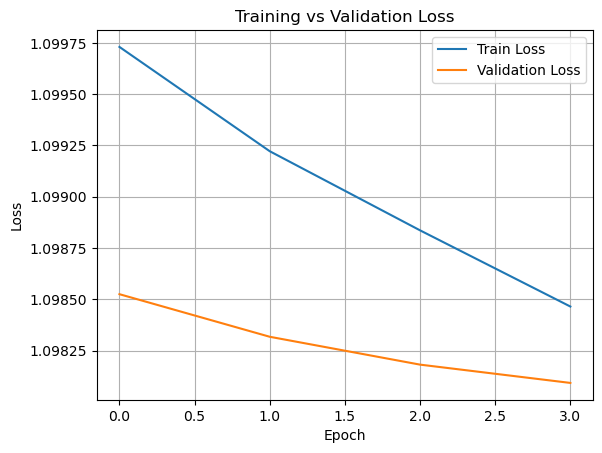

In [390]:
plt.plot(loss_tr, label='Train Loss')
plt.plot(dev_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [391]:
Y_te = np.argmax(Y_test_oh, axis=1)

In [392]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Y_te = np.argmax(Y_test_oh, axis=1) # Converting one-hot to integer labels

preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_pred']) for x in X_test] # Predicting labels on test set


print('Accuracy:', accuracy_score(Y_te, preds_te))
print('Precision:', precision_score(Y_te, preds_te, average='macro'))
print('Recall:', recall_score(Y_te, preds_te, average='macro'))
print('F1-Score:', f1_score(Y_te, preds_te, average='macro'))

IndexError: index 2996 is out of bounds for axis 0 with size 2993

Max index in x: 2


NameError: name 'emb_matrix' is not defined

In [39]:
print(np.unique(Y_test))  

[0 1 2]


### Discuss how did you choose model hyperparameters ? 

To choose the model hyperparameters, several configurations were tested and evaluated based on training/validation loss trends and final classification metrics on the test set. The learning rate was set to 0.001 as it is a widely used starting point that offers a good balance between convergence speed and stability. A lower learning rate ensures that the model learns gradually without overshooting the loss minimum. A dropout rate of 0.2 was used to prevent overfitting by randomly disabling 20% of the neurons during training. This rate was selected to introduce regularization without excessively weakening the learning capacity of the network. For the architecture, a hidden layer of size 128 was used 'hidden_dim = [128]' , as models without a hidden layer performed worse, and this configuration allowed the model to capture more abstract features from the input. The number of epochs was set to 100, but early stopping with a tolerance of 0.01 was implemented to halt training once validation loss stopped improving. This approach prevented overfitting and reduced unnecessary computation. Since the training used online (instance-wise) updates, batch size was not applicable. The selected hyperparameters provided a strong balance between performance and efficiency, leading to good generalization as reflected in the high accuracy and F1-score on the test set 

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [32]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [33]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [14]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

### Discuss how did you choose model hyperparameters ? 

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [13]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

### Discuss how did you choose model hyperparameters ? 

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |   |   |   |   |
| Average Embedding (Pre-trained)  |   |   |   |   |
| Average Embedding (Pre-trained) + X hidden layers    |   |   |   |   |


Please discuss why your best performing model is better than the rest and provide a brief error analaysis.